In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset.mask_functions import rle2mask, mask2rle
from dataset.dataset import prepare_trainset
from utils.utils import save_checkpoint, load_checkpoint, set_logger
from utils.gpu_utils import set_n_get_device

from model.model_unet import UNetResNet34, predict_proba
#from model.model_unet_classify_zero import UNetResNet34 as ZeroMaskClassifier

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("2", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None #[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = True # if True, load 100 samples
IMG_SIZE = None
BATCH_SIZE = 8
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: UNetResNet34====


## the dataset

In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count images in train/valid folder:  12568 1801
Count of trainset (for training):  1120
Count of validset (for training):  120


In [4]:
for i, (images, masks) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    masks = masks.to(device=device, dtype=torch.float)
    #labels = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float) #1 for non-zero-mask
    if i==0:
        break

In [5]:
images.size(), masks.size()

(torch.Size([8, 1, 256, 1600]), torch.Size([8, 4, 256, 1600]))

## the model

In [6]:
net = UNetResNet34(debug=True).cuda(device=device)
#net = ZeroMaskClassifier(debug=True).cuda(device=device)

#torch.cuda.set_device(0)
#torch.distributed.init_process_group(backend='nccl', world_size=4, init_method='...')
#net = DistributedDataParallel(net, device_ids=[0], output_device=0)
#torch.distributed.init_process_group(backend="nccl")

#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
#net, _ = load_checkpoint(checkpoint_path, net)

if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

In [7]:
logit = net(images)

input:  torch.Size([8, 3, 256, 1600])
e1 torch.Size([8, 64, 128, 800])
e2 torch.Size([8, 64, 128, 800])
e3 torch.Size([8, 128, 64, 400])


/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


e4 torch.Size([8, 256, 32, 200])
e5 torch.Size([8, 512, 16, 100])
center torch.Size([8, 256, 8, 50])
d5 torch.Size([8, 64, 16, 100])
d4 torch.Size([8, 64, 32, 200])
d3 torch.Size([8, 64, 64, 400])
d2 torch.Size([8, 64, 128, 800])
d1 torch.Size([8, 64, 256, 1600])
hypercolum torch.Size([8, 320, 256, 1600])
logit torch.Size([8, 4, 256, 1600])


/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
_loss = net.criterion(logit, masks)
_loss

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [9]:
_metric = net.metric(logit, masks)
_metric

tensor(0.0072, device='cuda:0')

## predict the validset, and analyse

In [ ]:
#move checkpoint from gamma machine to here
cd checkpoint
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/checkpoint/UNetResNet34_1024_v1_seed8901/ UNetResNet34_1024_v1_seed8901
cd logging
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/logging/UNetResNet34_1024_v1_seed8901.log UNetResNet34_1024_v1_seed8901.log

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pickle
import os
import logging
import time
import gc
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.utils import save_checkpoint, load_checkpoint, set_logger
from utils.gpu_utils import set_n_get_device

from dataset.dataset import prepare_trainset
from model.model_unet import UNetResNet34, predict_proba

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(x):
    return np.log(x / (1-x))

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0,1", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0,1] #None#[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = False # if True, load 100 samples
IMG_SIZE = (256,1600) #768#512#256
BATCH_SIZE = 8
NUM_WORKERS = 24


====MODEL ACHITECTURE: UNetResNet34====


In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count images in train/valid folder:  12568 1801
Count of trainset (for training):  11311
Count of validset (for training):  1257


In [4]:
# y should be makeup
y_valid = []
for i, (image, masks) in enumerate(val_dl):
    #if i==10:
    #    break
    truth = masks.to(device=device, dtype=torch.float)
    y_valid.append(truth.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(1256, 4, 256, 1600)

In [5]:
net = UNetResNet34(debug=False).cuda(device=device)

checkpoint_path = '../checkpoint/UNetResNet34_256x1600_v1_seed1234/best.pth.tar'

net, _ = load_checkpoint(checkpoint_path, net)
if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

In [6]:
%%time
preds_valid = predict_proba(net, val_dl, device, multi_gpu=multi_gpu, mode='valid', tta=True)

use TTA


/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CPU times: user 20min 13s, sys: 3min 35s, total: 23min 48s
Wall time: 1min 38s


In [7]:
y_valid.shape, preds_valid.shape

((1256, 4, 256, 1600), (1256, 4, 256, 1600))

In [ ]:
# with open('prediction/UNetResNet34_512_v1_seed5678__preds_valid.pkl', 'wb') as f:
#     pickle.dump(preds_valid, f)

In [ ]:
# ## ensemble logits
# with open('prediction/UNetResNet34_512_v1_seed1234__preds_valid.pkl', 'rb') as f:
#     preds_valid_1234 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed2345__preds_valid.pkl', 'rb') as f:
#     preds_valid_2345 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed3456__preds_valid.pkl', 'rb') as f:
#     preds_valid_3456 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed4567__preds_valid.pkl', 'rb') as f:
#     preds_valid_4567 = pickle.load(f)
# with open('prediction/UNetResNet34_512_v1_seed5678__preds_valid.pkl', 'rb') as f:
#     preds_valid_5678 = pickle.load(f)

# preds_valid = inverse_sigmoid((sigmoid(preds_valid_1234) + sigmoid(preds_valid_2345) + sigmoid(preds_valid_3456) + \
#                sigmoid(preds_valid_4567) + sigmoid(preds_valid_5678)) / 5)

# del preds_valid_1234, preds_valid_2345, preds_valid_3456, preds_valid_4567, preds_valid_5678
# gc.collect()

In [55]:
## search for best thresholds
def calculate_dice(logit, truth, EMPTY_THRESHOLD=[200,1500,1500,2000], MASK_THRESHOLD=0.22):
    n, c = truth.shape[0], truth.shape[1]
    logit = sigmoid(logit).reshape(n*c, -1)
    truth = truth.reshape(n*c, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    EMPTY_THRESHOLD_4ch = np.concatenate([EMPTY_THRESHOLD]*n)#.reshape(-1, 1)
    pred_clf = (pred.sum(axis=1)<EMPTY_THRESHOLD_4ch).astype(np.int)
    pred[pred_clf==1, ] = 0#.reshape(-1,)
    return dice_overall(pred, truth)

def dice_overall(pred_mask, truth_mask, eps=1e-8):
    #n, c = truth_mask.shape[0], truth_mask.shape[1]
    #pred_mask = pred_mask.reshape(n*c, -1)
    #truth_mask = truth_mask.reshape(n*c, -1)
    intersect = (pred_mask * truth_mask).sum(axis=1).astype(np.float)
    union = (pred_mask + truth_mask).sum(axis=1).astype(np.float)
    return ((2.0*intersect + eps) / (union+eps)).mean()

# h, w = 256, 1600
# print('For reference')
# print('EMPTY_THRESHOLD: ', 400*(h/256)*(w/1600))
# print('MASK_THRESHOLD: ', 0.5)

In [59]:
import copy

EMPTY_THRESHOLD_candidate = [250, 1000, 1000, 1500]#np.arange(400, 500, 100) #for 256x1600
MASK_THRESHOLD_candidate = [0.5]#np.arange(0.48, 0.50, 0.01)

M, N = len(EMPTY_THRESHOLD_candidate), len(MASK_THRESHOLD_candidate)
best_threshold_EMPTY = EMPTY_THRESHOLD_candidate
best_threshold_MASK = None
best_score = 0

for MASK_THRESHOLD in MASK_THRESHOLD_candidate:

    for EMPTY_THRESHOLD_ch1 in tqdm_notebook(np.arange(250, 500, 50)):
        EMPTY_THRESHOLD = copy.deepcopy(best_threshold_EMPTY)
        EMPTY_THRESHOLD[0] = EMPTY_THRESHOLD_ch1
        
        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD)
        print('CLF_EMPTY_THRESHOLD: %s, MASK_THRESHOLD: %f, dice_score: %f'%(str(EMPTY_THRESHOLD), MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold_EMPTY = copy.deepcopy(EMPTY_THRESHOLD)
            best_threshold_MASK = MASK_THRESHOLD
            best_score = dice_score
        
    for EMPTY_THRESHOLD_ch2 in tqdm_notebook(np.arange(800, 1200, 100)):
        EMPTY_THRESHOLD = copy.deepcopy(best_threshold_EMPTY)
        EMPTY_THRESHOLD[1] = EMPTY_THRESHOLD_ch2

        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD)
        print('CLF_EMPTY_THRESHOLD: %s, MASK_THRESHOLD: %f, dice_score: %f'%(str(EMPTY_THRESHOLD), MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold_EMPTY = copy.deepcopy(EMPTY_THRESHOLD)
            best_threshold_MASK = MASK_THRESHOLD
            best_score = dice_score
            
    for EMPTY_THRESHOLD_ch3 in tqdm_notebook(np.arange(800, 1200, 100)):
        EMPTY_THRESHOLD = copy.deepcopy(best_threshold_EMPTY)
        EMPTY_THRESHOLD[2] = EMPTY_THRESHOLD_ch3

        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD)
        print('CLF_EMPTY_THRESHOLD: %s, MASK_THRESHOLD: %f, dice_score: %f'%(str(EMPTY_THRESHOLD), MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold_EMPTY = copy.deepcopy(EMPTY_THRESHOLD)
            best_threshold_MASK = MASK_THRESHOLD
            best_score = dice_score
        
    for EMPTY_THRESHOLD_ch4 in tqdm_notebook(np.arange(1300, 1800, 100)):
        EMPTY_THRESHOLD = copy.deepcopy(best_threshold_EMPTY)
        EMPTY_THRESHOLD[3] = EMPTY_THRESHOLD_ch4

        dice_score = calculate_dice(preds_valid, y_valid, EMPTY_THRESHOLD, MASK_THRESHOLD)
        print('CLF_EMPTY_THRESHOLD: %s, MASK_THRESHOLD: %f, dice_score: %f'%(str(EMPTY_THRESHOLD), MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold_EMPTY = copy.deepcopy(EMPTY_THRESHOLD)
            best_threshold_MASK = MASK_THRESHOLD
            best_score = dice_score

CLF_EMPTY_THRESHOLD: [250, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920633
CLF_EMPTY_THRESHOLD: [300, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920531
CLF_EMPTY_THRESHOLD: [350, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920913
CLF_EMPTY_THRESHOLD: [400, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920849
CLF_EMPTY_THRESHOLD: [450, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920703


CLF_EMPTY_THRESHOLD: [350, 800, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920913
CLF_EMPTY_THRESHOLD: [350, 900, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920913
CLF_EMPTY_THRESHOLD: [350, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920913
CLF_EMPTY_THRESHOLD: [350, 1100, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920913


CLF_EMPTY_THRESHOLD: [350, 1000, 800, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920825
CLF_EMPTY_THRESHOLD: [350, 1000, 900, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920933
CLF_EMPTY_THRESHOLD: [350, 1000, 1000, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920913
CLF_EMPTY_THRESHOLD: [350, 1000, 1100, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920302


CLF_EMPTY_THRESHOLD: [350, 1000, 900, 1300], MASK_THRESHOLD: 0.500000, dice_score: 0.920933
CLF_EMPTY_THRESHOLD: [350, 1000, 900, 1400], MASK_THRESHOLD: 0.500000, dice_score: 0.920933
CLF_EMPTY_THRESHOLD: [350, 1000, 900, 1500], MASK_THRESHOLD: 0.500000, dice_score: 0.920933
CLF_EMPTY_THRESHOLD: [350, 1000, 900, 1600], MASK_THRESHOLD: 0.500000, dice_score: 0.920933
CLF_EMPTY_THRESHOLD: [350, 1000, 900, 1700], MASK_THRESHOLD: 0.500000, dice_score: 0.920904


In [60]:
best_threshold_EMPTY, best_threshold_MASK, best_score

([350, 1000, 900, 1500], 0.5, 0.9209332792760889)

In [61]:
def predict_mask(logit, EMPTY_THRESHOLD, MASK_THRESHOLD):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    #IMG_SIZE = logit.shape[-1] #256
    #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
    #MASK_THRESHOLD = 0.22
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if pred.sum() < EMPTY_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    else:
        return pred

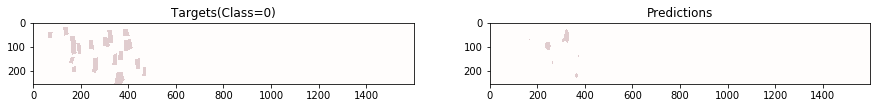

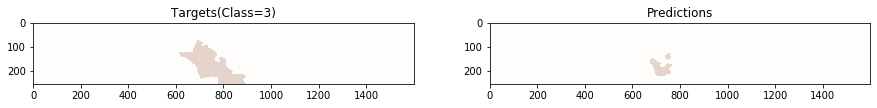

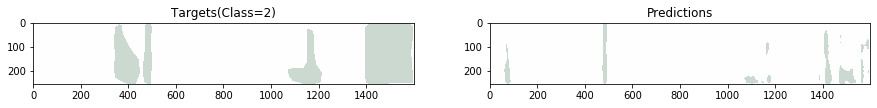

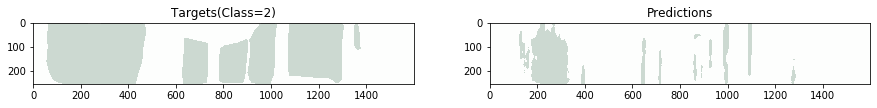

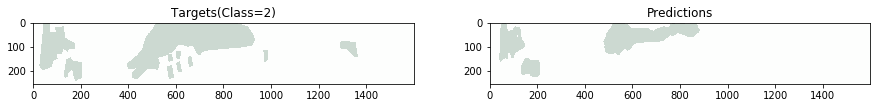

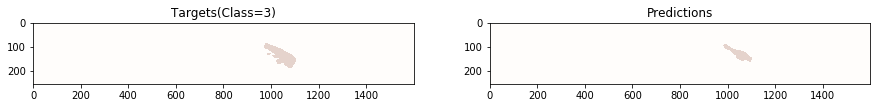

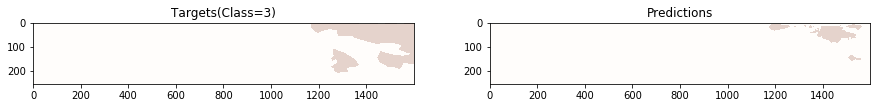

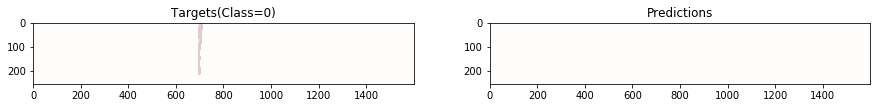

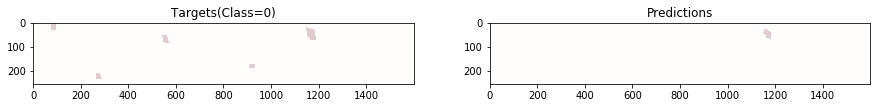

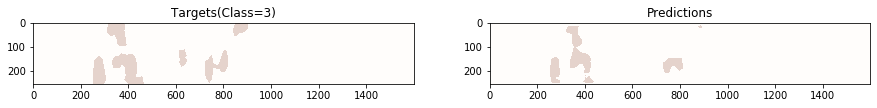

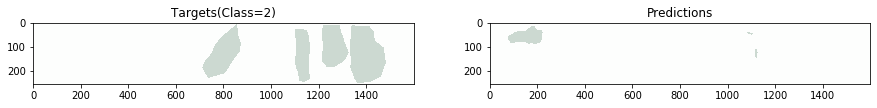

In [50]:
## visualize predicted masks
start = 1
rows = 10

cmaps = {0: "Reds", 1: "Blues", 2: "Greens", 3: "Oranges"}
titles = {0: "Class=1", 1: "Class=2", 2: "Class=3", 3: "Class=4"}

cnt = 0
for idx, (img, mask) in enumerate(val_dl):
    if idx<start:
        continue
    mask = mask.numpy()
    img = img.numpy()
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        not_empty = mask[j].reshape(4, -1).sum()>0
        if not_empty:
            cnt+=1
            ch = mask[j].reshape(4, -1).sum(axis=1).argmax()
            pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j][ch], EMPTY_THRESHOLD, MASK_THRESHOLD)#EMPTY_THRESHOLD=0
            #if pred_mask.sum()==0:
            #    continue
            fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
            #ax0.imshow(img[j][0], cmap='gray')
            ax0.imshow(mask[j][ch], cmap=cmaps[ch], alpha=0.2)
            #ax1.imshow(img[j][0], cmap='gray')
            ax1.imshow(pred_mask, cmap=cmaps[ch], alpha=0.2)
            if not_empty.item():
                ax0.set_title('Targets(Class=%d)'%ch)
            else:
                ax0.set_title('Targets(Empty)')
            ax1.set_title('Predictions')
        if cnt>rows:
            break
    if cnt>rows:
            break

## This is moved to kaggle kernel=============predict the testset

In [68]:
import glob
from dataset.dataset import prepare_testset

In [70]:
test_fnames = [f.split('/')[-1] for f in glob.glob('../data/raw/test/*')]
len(test_fnames), test_fnames[0]

(1801, 'acecbd93a.jpg')

In [71]:
test_dl = prepare_testset(BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

In [72]:
%%time
preds_test = predict_proba(net, test_dl, device, multi_gpu=multi_gpu, mode='test', tta=True)

use TTA


/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CPU times: user 40min 47s, sys: 12min 36s, total: 53min 23s
Wall time: 3min 21s


In [ ]:
# %%time
# ##for ensemble
# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed1234/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_1234 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed1234 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed2345/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_2345 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed2345 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_3456 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed3456 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed4567/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_4567 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed4567 complete')

# net = UNetResNet34(debug=False).cuda(device=device)
# checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed5678/best.pth.tar'
# net, _ = load_checkpoint(checkpoint_path, net)
# preds_test_5678 = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)
# print('seed5678 complete')

# with open('prediction/UNetResNet34_512_v1__preds_test.pkl', 'wb') as f:
#     pickle.dump([preds_test_1234, preds_test_2345, preds_test_3456, preds_test_4567, preds_test_5678], 
#                 f)

# preds_test = inverse_sigmoid((sigmoid(preds_test_1234) + sigmoid(preds_test_2345) + sigmoid(preds_test_3456) + \
#                sigmoid(preds_test_4567) + sigmoid(preds_test_5678)) / 5)

# del preds_test_1234, preds_test_2345, preds_test_3456, preds_test_4567, preds_test_5678
# gc.collect()

In [73]:
preds_test.shape

(1801, 4, 256, 1600)

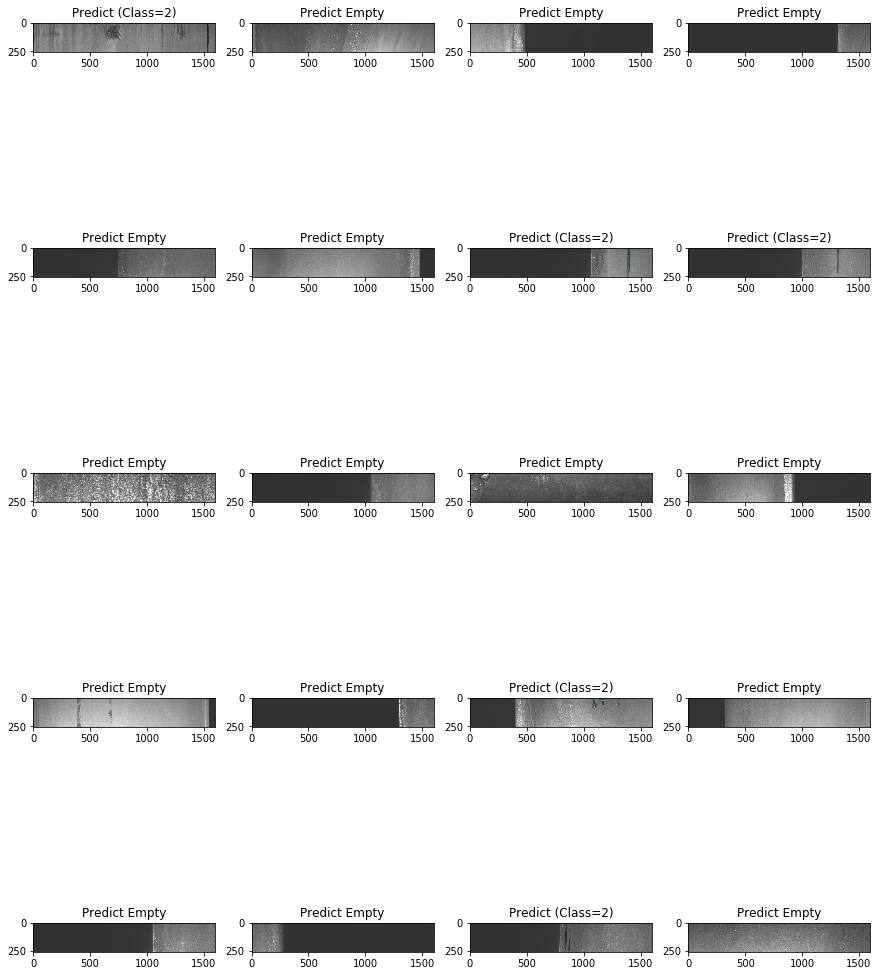

In [74]:
## visualize predicted masks
start = 0
total = 19

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, img in enumerate(test_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        ch = preds_test[idx*BATCH_SIZE+j].reshape(4, -1).sum(axis=1).argmax()
        pred_mask = predict_mask(preds_test[idx*BATCH_SIZE+j][ch], EMPTY_THRESHOLD, MASK_THRESHOLD)#EMPTY_THRESHOLD=0
        #if pred_mask.float().mean()==0:
        #    continue
        ax = fig.add_subplot(5, 4, cnt)
        plt.imshow(img[j][0].numpy(), cmap='gray')
        plt.imshow(pred_mask, alpha=0.2, cmap=cmaps[ch])
        if pred_mask.sum()>0:
            plt.title('Predict (Class=%d)'%ch)
        else:
            plt.title('Predict Empty')
        if cnt>total:
            break
    if cnt>total:
            break

## build submission

In [75]:
import PIL
from dataset.mask_functions import mask2rle

In [109]:
%%time
#### Step 1: Generate rle encodings (images are first converted to the original size)
rles = []
for p in tqdm_notebook(preds_test):#p is logit from model
    for ch in range(4):
        pred_mask = predict_mask(p[ch], EMPTY_THRESHOLD, MASK_THRESHOLD)
        rles.append(mask2rle(pred_mask))
#         if pred_mask.sum()>0:#predicted non-empty mask
#             im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
#             im = np.asarray(im)
#             rles.append(mask2rle(im, 1024, 1024))
#         else: rles.append('-1')

img_id_ch = []
for fname in test_fnames:
    for i in range(4):
        img_id_ch.append(fname+'_%d'%(i+1))

sub_df = pd.DataFrame({'ImageId_ClassId': img_id_ch, 'EncodedPixels': rles})
print(len(sub_df.index))
sub_df.head()


7204
CPU times: user 7min 6s, sys: 12.2 s, total: 7min 19s
Wall time: 27.5 s


,ImageId_ClassId,EncodedPixels
0,acecbd93a.jpg_1,
1,acecbd93a.jpg_2,
2,acecbd93a.jpg_3,390758 38 390801 58 390861 2 390882 14 390918 ...
3,acecbd93a.jpg_4,
4,db9d34c52.jpg_1,


In [115]:
#print(preds_test.shape)

#pred_mask = predict_mask(preds_test[0][2], EMPTY_THRESHOLD, MASK_THRESHOLD)
#mask2rle(pred_mask)
#pred_mask.shape

#sub_df.loc[sub_df.ImageId_ClassId=='01b47d973.jpg_3', 'EncodedPixels'].values[0]

In [117]:
#sub_df.head()

In [156]:
# check the correctness of transformation
pred_mask = predict_mask(preds_test[32][2], EMPTY_THRESHOLD, MASK_THRESHOLD)
pred_mask.sum()

19903

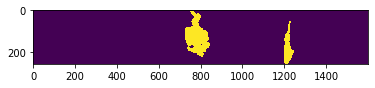

In [157]:
plt.imshow(pred_mask)

In [162]:
sub_df.to_csv('../submission/0913_unet_seed1234_tta_v1_400_048.csv.gz', index=False, compression='gzip')

In [161]:
(sub_df.EncodedPixels!='').mean()

0.11937812326485286